# Plotting Notebook
This notebook displays and manipulates the histograms produced by `make_plots.py`. <br>
Please use this is a guide to the type plots that you can create, as examples of the `hist`, `mplhep`, and other packages, as well as the use of the various functions that we have written in `plot_utils.py`. <br>
Use the the Table of Contents in Jupyter to view the different sections of the notebook to help navigating it.

In [3]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import itertools
import warnings
import json
from plot_utils import *

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})
matplotlib.rcParams['figure.facecolor'] = 'white'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [4]:
# parameters
output_label = '/home/submit/lavezzo/public_html/SUEP/analysis/inference/'
file_ext = '.png'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [5]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions of plots: (sample) x (plot label)
# N.B.: lumis are applied through loader()

# input .pkl files
plotDir = '/work/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl')

# offline_files_SUEP = [f for f in infile_names if "inference7_unblindISR.pkl" in f and ('SUEP-m' in f)]
# plots_SUEP = loader(offline_files_SUEP, apply_lumis=True, exclude_low_bins=True)
# offline_files_data2018 = [f for f in infile_names if "inference7_unblindISR.pkl" in f and ('Run2018' in f)]
# plots_data2018 = loader(offline_files_data2018, apply_lumis=False, exclude_low_bins=False)
offline_files_2018 = [f for f in infile_names if "test_GNNsys.pkl" in f and ('20UL18' in f or 'Run2018' in f)]
plots_2018 = loader(offline_files_2018, apply_lumis=True, exclude_low_bins=True)
# offline_files_2017 = [f for f in infile_names if "inference6.pkl" in f and ('20UL17' in f or 'Run2017' in f)]
# plots_2017 = loader(offline_files_2017, apply_lumis=True, exclude_low_bins=True)
# offline_files_2016 = [f for f in infile_names if "inference6.pkl" in f and ('20UL16' in f or 'Run2016' in f)]
# plots_2016 = loader(offline_files_2016, apply_lumis=True, exclude_low_bins=True)

# put everything in one dictionary
plots = {}

# for key in plots_SUEP.keys(): plots[key] = plots_SUEP[key]
# for key in plots_data2018.keys(): plots[key+"_2018"] = plots_data2018[key]
for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
# for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
# for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]
# plots['QCD_HT_allyears'] = combineYears(plots,'QCD_HT', ['2018','2017','2016'])
# plots['data_allyears'] = combineYears(plots,'data', ['2018','2017','2016'])

These are all the samples loaded.

In [6]:
### TEMPORARY I DON'T WANT THIS HERE

def applySUEPxsecs(plots):
    
    new_plots_dict = {}
    for sample, plot_dict in plots.items():
        if 'SUEP-m' not in sample:
            new_plots_dict[sample] = plot_dict
            continue
        
        mass = sample.split("SUEP-m")[1]
        mass = mass.split('-')[0]
        mass = str(mass)
        
        xsec = getXSection(mass, 2018, SUEP=True)
        
        new_plots_dict[sample] = {}
        for key, plot in plot_dict.items():
            new_plots_dict[sample][key] = plot * xsec
            
    return new_plots_dict
        
plots = applySUEPxsecs(plots)

In [7]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

1000to1500_2018
1500to2000_2018
2000toInf_2018
200to300_2018
300to500_2018
500to700_2018
QCD_HT_2018


## 1D Plots
Plot some of the 1D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_labels`: _list of str_, which plots to show.<br>
`samples`: _list of str_, which samples to include in the plot.

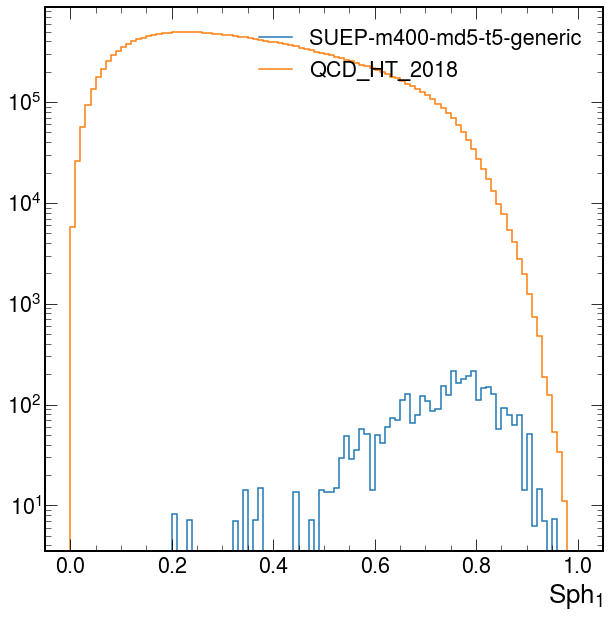

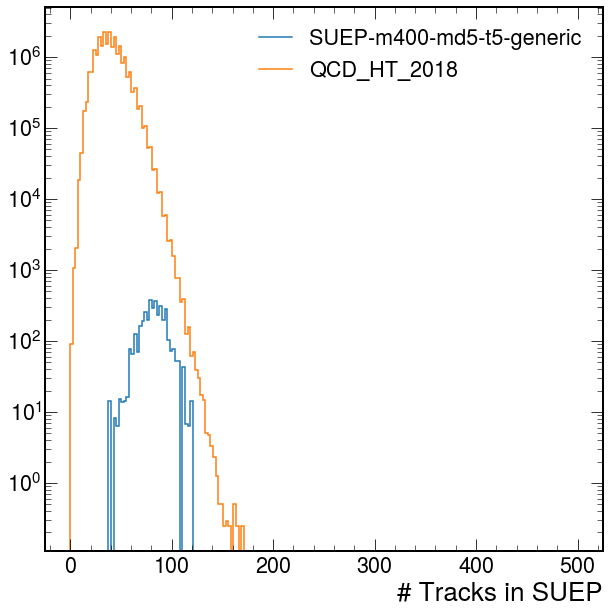

In [6]:
plot_labels = ['SUEP_S1_Cluster', 'SUEP_nconst_Cluster']
samples = ['SUEP-m400-md5-t5-generic', 'QCD_HT_2018']
density = False

for plot_label in plot_labels:
    for sample in samples: 
        h = plots[sample][plot_label][::]                  
        if density: h = h/h.sum().value
        hep.histplot(h, yerr=False, label=sample) 

    # tweak these by hand, as needed
    # plt.ylim(1e4,1e6)
    # plt.xlim(-1000,0 )
    plt.legend()
    plt.yscale("log")
    
    # save and show
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

## 2D Plots

Plot some of the 2D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_label`: _str_, which plot to show.<br>
`samples`: _list of str_, which samples to include in the plot.<br>
`draw_lines`: _bool_, whether to draw lines in following arguments.<br>
`lines_<dimension>`: _list of floats_, draws lines at given values.

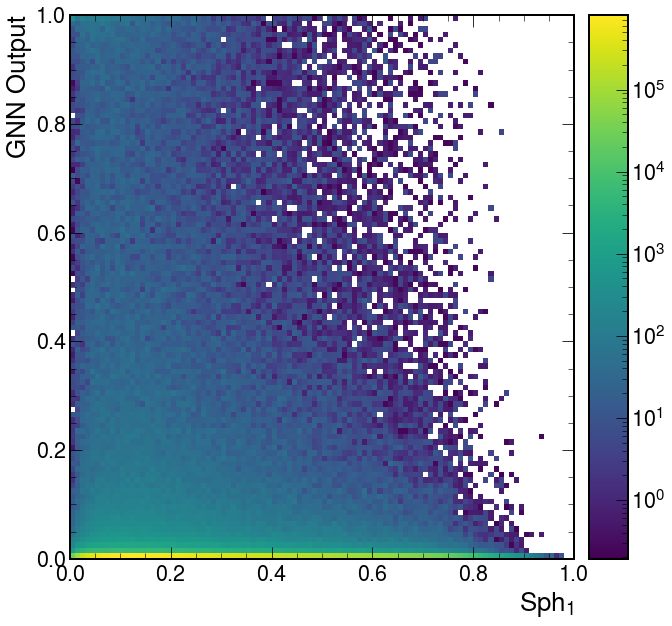

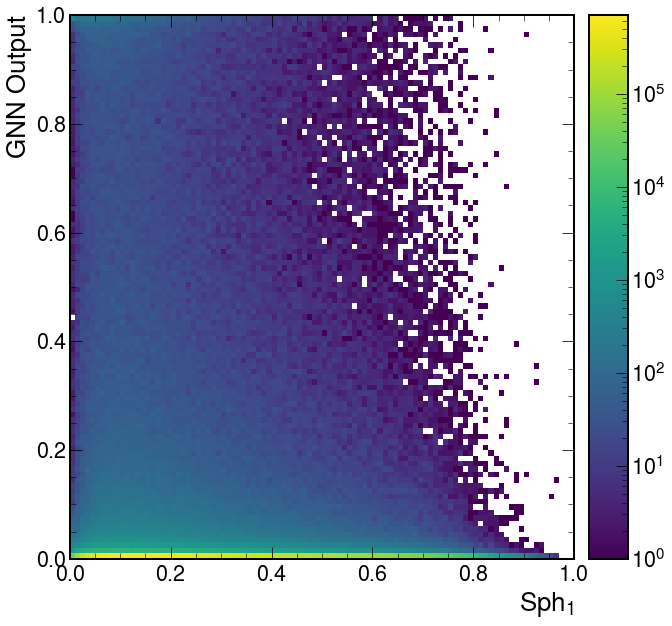

In [10]:
plot_label = '2D_ISR_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted'
samples = ['QCD_HT_2018', 'data_2018']
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = False
lines_x = [0.35,0.4, 0.5]
lines_y = [10,40,80]

for sample in samples:
    
    if plots[sample][plot_label].sum().value == 0:
        print("Histogram empty for sample", sample)
        continue

    hep.hist2dplot(plots[sample][plot_label], 
               norm=matplotlib.colors.LogNorm(),
               label=sample) 
    
    # draw lines to visualize selections, ABCD regions, etc.
    if draw_lines:
        for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
        for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')
    
    #plt.xlim(0,200)
    plt.savefig(output_label + plot_label+ "_"+sample+file_ext)
    plt.show()

### 2D Hist Slices Stacked
Slice a 2D histogram and plot the stacked slices individually.

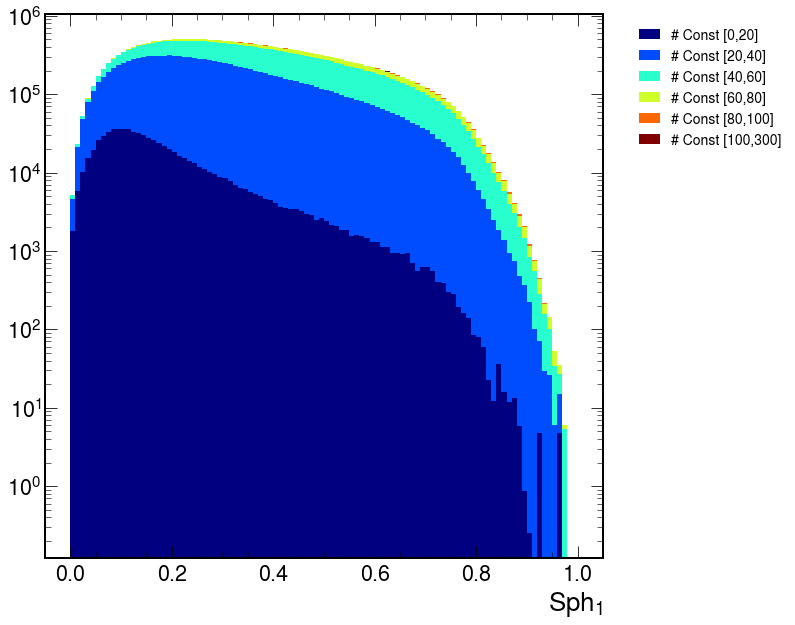

In [14]:
sample = 'QCD_HT_2018'
slice_var = 'y'
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'

regions_list = [[0.0j,20j],[20j,40j],[40j,60j],
                [60j,80j],[80j,100j],[100j,300j]]
labels = ["# Const [{},{}]".format(int(regions[0].imag), int(regions[1].imag)) for regions in regions_list]

h = plots[sample][plot_label]
fig, ax = plot_sliced_hist2d(h, regions_list, slice_var=slice_var, labels=labels)

## Ratio Plots

### Compare Datasets
Make ratio plots of different datasets.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list of str_, which plots to make.

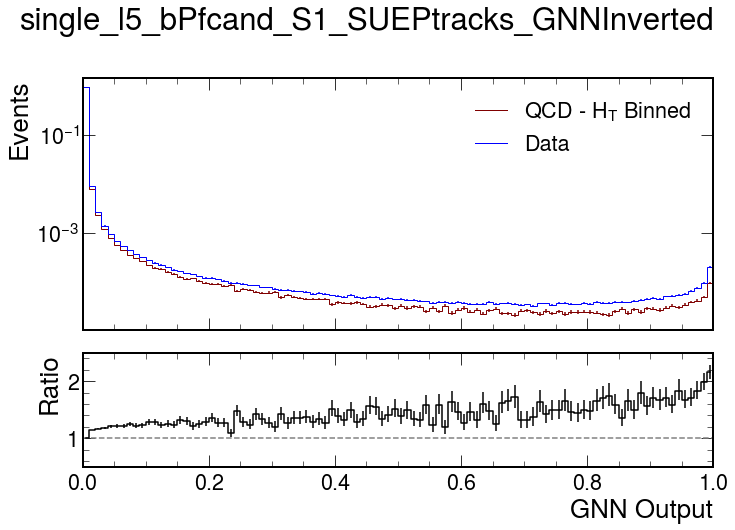

In [6]:
selection = 'GNNInverted'
plot_labels = ['single_l5_bPfcand_S1_SUEPtracks']
density = True
sample1 = 'QCD_HT_2018'
sample2 = 'data_2018'

for plot_label in plot_labels:
    
    plot_label += '_'+selection

    h1 = plots[sample1][plot_label][::1j]
    h2 = plots[sample2][plot_label][::1j]
    
    # our custom ratio calculates errors differently, more appropriate for plotting densities
    if density:
        h1 = h1/h1.sum().value
        h2 = h2/h2.sum().value
        fig, axs, _ = plot_ratio(h1, h2, label1=r'QCD - $H_T$ Binned', label2 = 'Data')
        axs[0].legend()
        axs[1].set_ylim(0.5,2.5)
        
    else:            
        fig = plt.figure(figsize=(10, 8))
        
        _ = h1.plot_ratio(h2,
                         rp_num_label=r'QCD MC - $H_T$ Binned',
                         rp_denom_label='Data')
        fig.axes[0].set_yscale("log")
        #fig.axes[0].set_xlim(0, 2000)
        #fig.axes[0].set_ylim(1e-5, 1e7)
        fig.axes[1].set_ylim(0.0,1.5)
        fig.axes[1].set_ylabel('MC/data')
    
    fig.figure.suptitle(plot_label)
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

### Ratio Plots: Shared x-axis
Make ratio plots for different datasets of all regions combined into one histogram.<br>

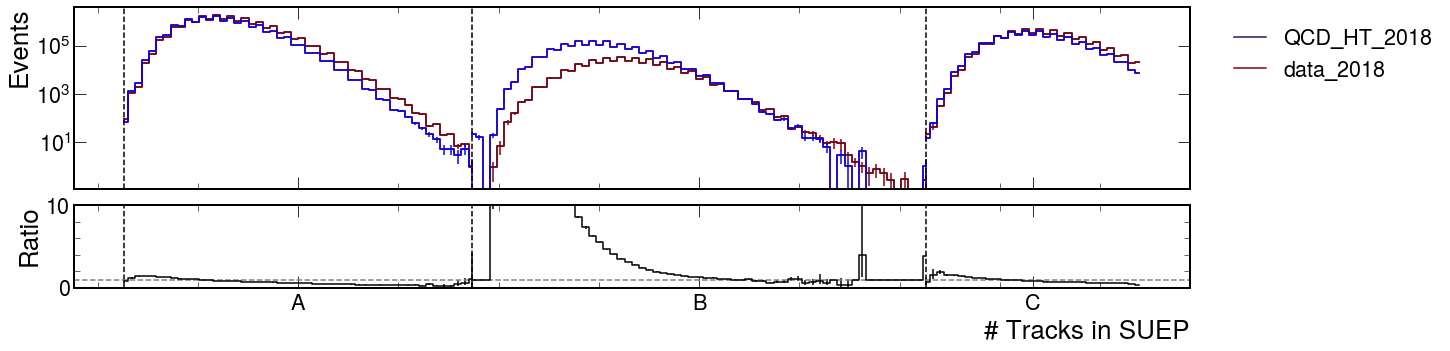

In [10]:
x = 'ABC'
y = 'ACB'
plot_labels = ['SUEP_nconst_GNN']
sample1 = 'QCD_HT_2018'
sample2 = 'data_2018'
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           sample1, sample2, 
                           x, density=False)
    ax2.set_ylim(0,10)
    fig.savefig(output_label + plot_label + file_ext, bbox_inches='tight')

### Compare Variables

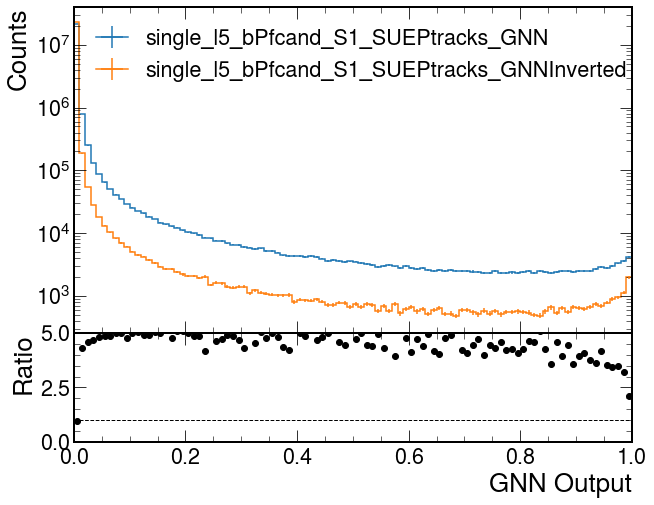

In [17]:
plot_label1 = "single_l5_bPfcand_S1_SUEPtracks_GNN"
plot_label2 = "single_l5_bPfcand_S1_SUEPtracks_GNNInverted"
sample = 'QCD_HT_2018'
density = False

# QCD hist for ABCD region
h1 = plots[sample][plot_label1]
h2 = plots[sample][plot_label2]

if density:
    h1 = h1/h1.sum().value
    h2 = h2/h2.sum().value

fig = plt.figure(figsize=(10, 8))

_ = h1.plot_ratio(h2,
                 rp_num_label=plot_label1,
                 rp_denom_label=plot_label2)

fig.axes[0].set_yscale("log")
# fig.axes[0].set_xlabel("pT")
#fig.axes[0].set_xlim(0, 2000)
#fig.axes[0].set_ylim(1e-5, 1e7)
fig.axes[1].set_ylim(0,5)
plt.savefig(output_label + plot_label1 + "_" + plot_label2 + file_ext, bbox_inches='tight')
plt.show()

In [ ]:
'200to300_2018', 'QCD_HT_2018', '1000to1500_2018', '500to700_2018', '2000toInf_2018', '100to200_2018', '300to500_2018', '1500to2000_2018']

In [37]:
print(plots['1000to1500_2018']['SUEP_S1_Cluster'].sum().value)
print(plots['1000to1500_2018']['ISR_S1_ClusterInverted'].sum().value)

16373460.898363952
16373216.060581151


In [47]:
print(plots['1000to1500_2018']['SUEP_S1_GNN'].sum().value)
print(plots['1000to1500_2018']['ISR_S1_GNNInverted'].sum().value)

16373464.986145003
16373464.986143047


### Ratios of Slices
Slice a 2D histogram for both two samples or variables and plot ratio of each of the slices.

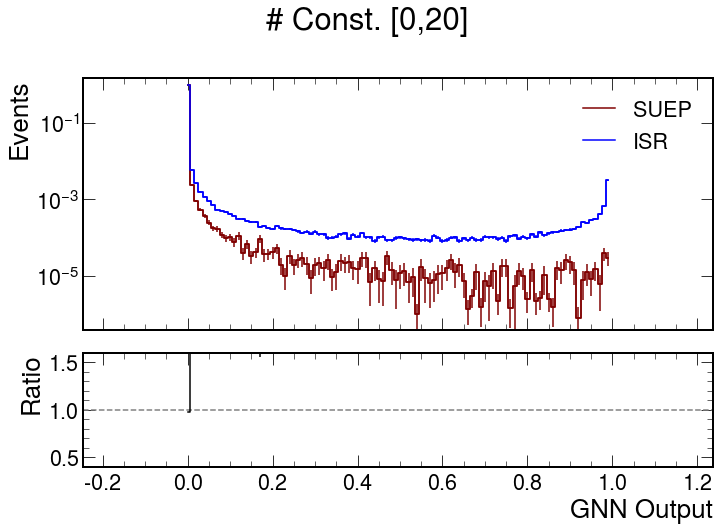

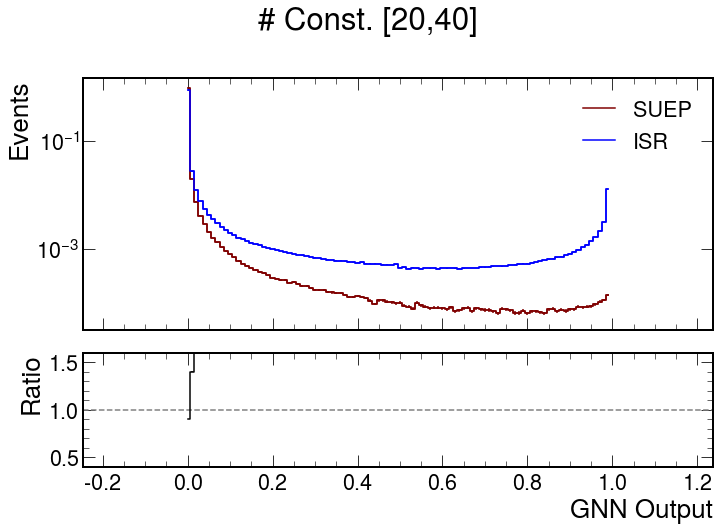

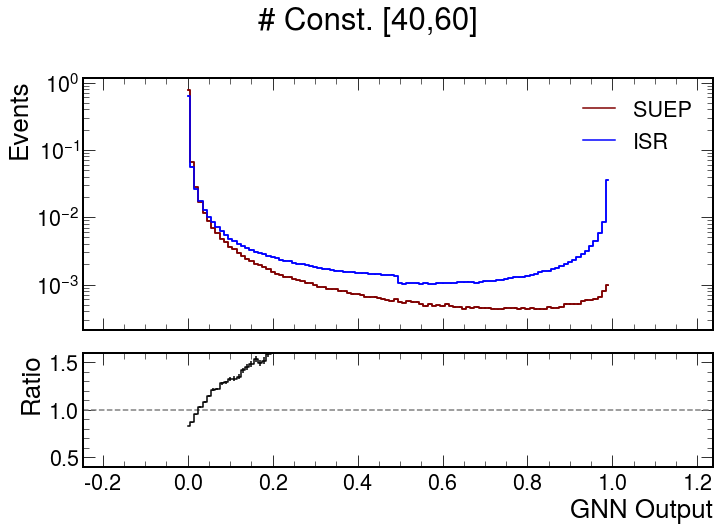

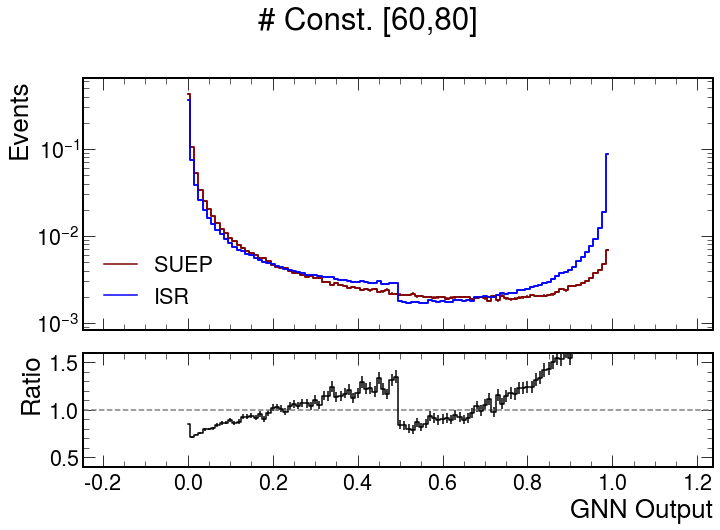

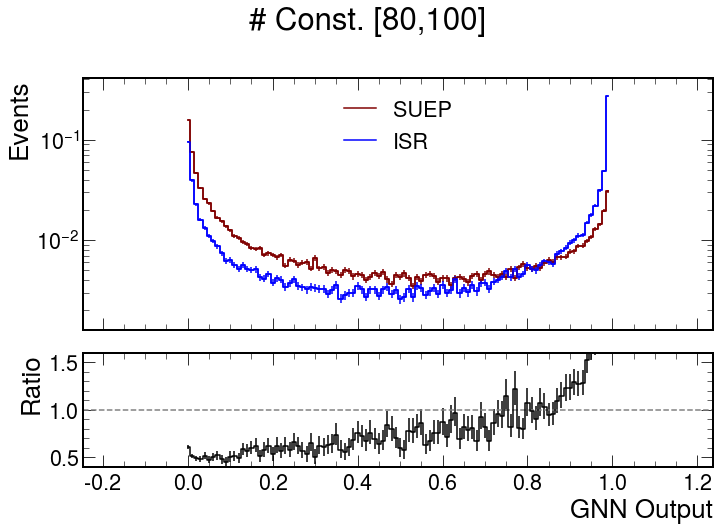

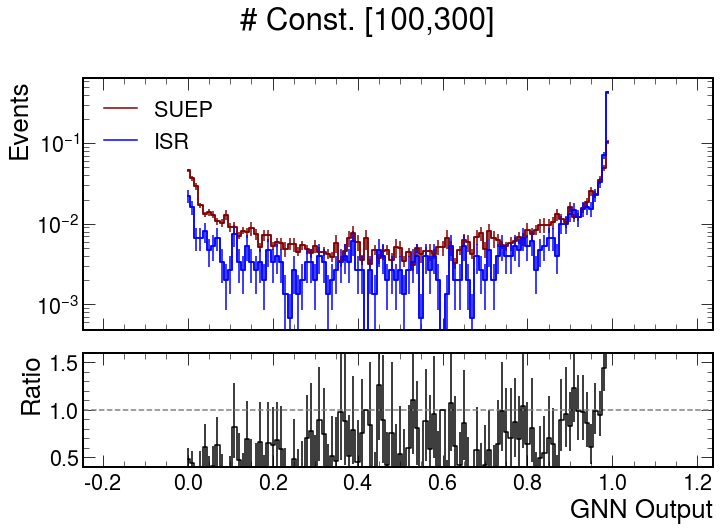

In [12]:
h1 = plots['QCD_HT_2018']["2D_SUEP_nconst_vs_single_l5_bPfcand_S1_GNN"]
h2 = plots['data_2018']["2D_SUEP_nconst_vs_single_l5_bPfcand_S1_GNN"]

regions_list = [[0.0j,20j],[20j,40j],[40j,60j],
                [60j,80j],[80j,100j],[100j,300j]]
h1_slices = slice_hist2d(h1, regions_list, slice_var='x')
h2_slices = slice_hist2d(h2, regions_list, slice_var='x')

for h1_slice, h2_slice, regions in zip(h1_slices, h2_slices, regions_list):
    
    h1_slice = h1_slice[:]
    h2_slice = h2_slice[:]
    
    h1_slice = h1_slice/h1_slice.sum().value
    h2_slice = h2_slice/h2_slice.sum().value
  
    fig, axs, _ = plot_ratio(h1_slice, h2_slice, label1='SUEP', label2='ISR')
    axs[0].legend()

    fig.suptitle("# Const. [{},{}]".format(int(regions[0].imag), int(regions[1].imag)))
    plt.show()

### Weights

In [ ]:
plot_label = 'SUEP_nconst_CL'
regions = x = 'ABCDEFGHI'
density = False

weights = nested_dict(2, float)
for r in regions:
    
    plot = r + "_" + plot_label
    
    # control regions
    if r != 'I':
        h1 = plots['QCD_HT'][plot]
        h2 = plots['data'][plot]

        fig, _, res = plot_ratio(h1, h2)
        plt.close()

        x = h1.to_numpy()[1]
        ratios = res[0]+1

        weights[r]['bins'] = x
        weights[r]['ratios'] = ratios
    
    # signal region
    else:
        
        h1 = plots['QCD_HT']['F_'+plot_label]
        F = h1.sum().value
        G = plots['QCD_HT']['G_'+plot_label].sum().value
        C = plots['QCD_HT']['C_'+plot_label].sum().value
        A = plots['QCD_HT']['A_'+plot_label].sum().value
        H = plots['QCD_HT']['H_'+plot_label].sum().value
        E = plots['QCD_HT']['E_'+plot_label].sum().value
        D = plots['QCD_HT']['D_'+plot_label].sum().value
        B = plots['QCD_HT']['B_'+plot_label].sum().value
        
        h1 = h1 * F**3 * (G * C / A) * \
                ((H / E)**4) \
                * (G * F / D)**-2 \
                * (H * C / B)**-2
        
        h2 = plots['data']['F_'+plot_label]
        F = h2.sum().value
        G = plots['data']['G_'+plot_label].sum().value
        C = plots['data']['C_'+plot_label].sum().value
        A = plots['data']['A_'+plot_label].sum().value
        H = plots['data']['H_'+plot_label].sum().value
        E = plots['data']['E_'+plot_label].sum().value
        D = plots['data']['D_'+plot_label].sum().value
        B = plots['data']['B_'+plot_label].sum().value
        
        h2 = h2 * F**3 * (G * C / A) * \
                ((H / E)**4) \
                * (G * F / D)**-2 \
                * (H * C / B)**-2
        
        fig, _, res = plot_ratio(h1, h2, plot, 'QCD_HT', 'data')
        plt.close()
        
        x = h1.to_numpy()[1]
        ratios = res[0]+1

        weights[r]['bins'] = x
        weights[r]['ratios'] = ratios
        
weights = dict(weights)
np.save('nconst_weights', weights)

## Automatic Plotting
Make all plots in the pkl and save them automatically.<br>

### All 1D and 2D Plots

In [12]:
outdir = 'allplots/'
samples = ['QCD_HT', 'QCD_HT_scout']
density = True

plot_labels = [k for k in list(plots['QCD_HT'].keys())]
if not os.path.isdir(output_label+outdir): os.system("mkdir " + str(output_label+outdir))

for plot_label in plot_labels:
    
    # 2D plots
    if '2D' in plot_label:
        
        print(plot_label, end=", ")
        
        for sample in samples:

            if plots[sample][plot_label].sum().value == 0:
                print("Histogram empty for sample", sample, end=", ")
                continue

            h = plots[sample][plot_label]
            hep.hist2dplot(h, 
                       norm=matplotlib.colors.LogNorm(),
                       label=sample) 
            plt.savefig(output_label + outdir + plot_label+ "_"+sample+file_ext, bbox_inches='tight')
            plt.close()
        
    # 1D variables
    elif '2D' not in plot_label:
    
        print(plot_label, end=", ")
        
        if plots[sample][plot_label].sum().value == 0:
                print("Histogram empty for sample", sample, end=", ")
                continue
        
        # plot everything
        for sample in samples:
            h = plots[sample][plot_label]
            if density: h = h/h.sum().value
            hep.histplot(h, yerr=True, label=sample) 
        plt.legend()
        plt.yscale("log")
        plt.savefig(output_label + 'allplots/' + plot_label+ "_all"+file_ext, bbox_inches='tight')
        plt.close()

    print()
print("All done")

ABCDvars_ISRRemoval, Histogram empty for sample QCD_HT_scout, ht_ISRRemoval, 
ht_tracker_ISRRemoval, 
ntracks_ISRRemoval, 
ngood_fastjets_ISRRemoval, 
PV_npvs_ISRRemoval, 
Pileup_nTrueInt_ISRRemoval, Histogram empty for sample QCD_HT_scout, ngood_ak4jets_ISRRemoval, 
ngood_tracker_ak4jets_ISRRemoval, 
FNR_ISRRemoval, Histogram empty for sample QCD_HT_scout, ISR_contamination_ISRRemoval, Histogram empty for sample QCD_HT_scout, A_ht_ISRRemoval, 
A_ht_tracker_ISRRemoval, 
A_ntracks_ISRRemoval, 
A_ngood_fastjets_ISRRemoval, 
A_PV_npvs_ISRRemoval, 
A_Pileup_nTrueInt_ISRRemoval, Histogram empty for sample QCD_HT_scout, A_ngood_ak4jets_ISRRemoval, 
A_ngood_tracker_ak4jets_ISRRemoval, 
A_FNR_ISRRemoval, Histogram empty for sample QCD_HT_scout, A_ISR_contamination_ISRRemoval, Histogram empty for sample QCD_HT_scout, B_ht_ISRRemoval, 
B_ht_tracker_ISRRemoval, 
B_ntracks_ISRRemoval, 
B_ngood_fastjets_ISRRemoval, 
B_PV_npvs_ISRRemoval, 
B_Pileup_nTrueInt_ISRRemoval, Histogram empty for sample QCD

### All Ratios: 1D Plots
For each 1D histogram, make a ratio plot between two samples.

In [18]:
plot_labels = list(plots['QCD_HT_2018'].keys())
density = False
combos = [['QCD_HT_2018','data_2018']]

for l1, l2 in combos:
    
    outdir = l1+"_"+l2+"/"
    print(outdir)

    if not os.path.isdir(output_label+outdir): 
        os.system("mkdir " + str(output_label+outdir))

    for plot_label in plot_labels:

        if '2D' in plot_label: continue

        print(plot_label, end=", ")
        h1 = plots[l1][plot_label]
        h2 = plots[l2][plot_label]
        
        if h1.sum().value == 0 or h2.sum().value == 0: continue
        
        if density: 
            h1 = h1/h1.sum().value
            h2 = h2/h2.sum().value
            fig, axs, _ = plot_ratio(h1, h2, label1=l1, label2=l2)
            axs[0].legend()
        else:
            fig = plt.figure(figsize=(10, 8))
            _ = h1.plot_ratio(h2,
                             rp_num_label=l1,
                             rp_denom_label=l2)
            fig.axes[0].set_yscale("log")
            fig.axes[1].set_ylim(0.4,1.6)
            
        plt.savefig(output_label + outdir + plot_label +file_ext, bbox_inches='tight')
        plt.close()

    print("All done")

QCD_HT_2018_data_2018/
ABCDvars_ISRRemoval, ht_ISRRemoval, ntracks_ISRRemoval, ngood_fastjets_ISRRemoval, PV_npvs_ISRRemoval, Pileup_nTrueInt_ISRRemoval, ngood_ak4jets_ISRRemoval, ngood_tracker_ak4jets_ISRRemoval, FNR_ISRRemoval, ISR_contamination_ISRRemoval, A_ht_ISRRemoval, A_ntracks_ISRRemoval, A_ngood_fastjets_ISRRemoval, A_PV_npvs_ISRRemoval, A_Pileup_nTrueInt_ISRRemoval, A_ngood_ak4jets_ISRRemoval, A_ngood_tracker_ak4jets_ISRRemoval, A_FNR_ISRRemoval, A_ISR_contamination_ISRRemoval, B_ht_ISRRemoval, B_ntracks_ISRRemoval, B_ngood_fastjets_ISRRemoval, B_PV_npvs_ISRRemoval, B_Pileup_nTrueInt_ISRRemoval, B_ngood_ak4jets_ISRRemoval, B_ngood_tracker_ak4jets_ISRRemoval, B_FNR_ISRRemoval, B_ISR_contamination_ISRRemoval, C_ht_ISRRemoval, C_ntracks_ISRRemoval, C_ngood_fastjets_ISRRemoval, C_PV_npvs_ISRRemoval, C_Pileup_nTrueInt_ISRRemoval, C_ngood_ak4jets_ISRRemoval, C_ngood_tracker_ak4jets_ISRRemoval, C_FNR_ISRRemoval, C_ISR_contamination_ISRRemoval, D_ht_ISRRemoval, D_ntracks_ISRRemoval,

### All Ratios: Combined Regions

In [20]:
density = True

plot_labels = list(plots['QCD_HT_2018'].keys())
combos = [['QCD_HT_2018','data_2018']]

for l1, l2 in combos:
    
    outdir = l1+"_"+l2+"_combinedRegions/"
    print(outdir)

    if not os.path.isdir(output_label+outdir): 
        os.system("mkdir " + str(output_label+outdir))

    for plot_label in plot_labels:

        if "A_" not in plot_label: continue
        print(plot_label, end=", ")
        
        h1 = plots[l1][plot_label.replace("A_", "")]
        h2 = plots[l2][plot_label.replace("A_", "")]
        if h1.sum().value == 0 or h2.sum().value == 0:
            print("Empty", end=", ")
            continue
            
        # x or y define order of regions
        x = 'ABCDEFGH'
        y = 'ADGBEHCF'
        _ = plot_ratio_regions(plots, plot_label, l1, l2, x, density=density)
        plt.savefig(output_label + outdir + plot_label +file_ext, bbox_inches='tight')
        plt.close()

QCD_HT_2018_data_2018_combinedRegions/
A_ht_ISRRemoval, A_ntracks_ISRRemoval, A_ngood_fastjets_ISRRemoval, A_PV_npvs_ISRRemoval, A_Pileup_nTrueInt_ISRRemoval, Empty, A_ngood_ak4jets_ISRRemoval, A_ngood_tracker_ak4jets_ISRRemoval, Empty, A_FNR_ISRRemoval, Empty, A_ISR_contamination_ISRRemoval, Empty, A_SUEP_nconst_ISRRemoval, A_SUEP_pt_ISRRemoval, A_SUEP_pt_avg_ISRRemoval, A_SUEP_pt_avg_b_ISRRemoval, A_SUEP_pt_mean_scaled_ISRRemoval, A_SUEP_eta_ISRRemoval, A_SUEP_phi_ISRRemoval, A_SUEP_mass_ISRRemoval, A_SUEP_S1_ISRRemoval, A_SUEP_girth, Empty, A_SUEP_rho0_ISRRemoval, A_SUEP_rho1_ISRRemoval, A_ht_Cluster, A_ntracks_Cluster, A_ngood_fastjets_Cluster, A_PV_npvs_Cluster, A_Pileup_nTrueInt_Cluster, Empty, A_ngood_ak4jets_Cluster, A_ngood_tracker_ak4jets_Cluster, Empty, A_FNR_Cluster, Empty, A_ISR_contamination_Cluster, Empty, A_SUEP_nconst_Cluster, A_SUEP_pt_Cluster, A_SUEP_pt_avg_Cluster, A_SUEP_pt_avg_b_Cluster, A_SUEP_pt_mean_scaled_Cluster, A_SUEP_eta_Cluster, A_SUEP_phi_Cluster, A_SUEP

## Binned QCD Plots
Make plots with the QCD separated by bins. This won't work if QCD has been marged. <br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list_, which plots you want to make.<br>
`identifier`: _str_, how to identify the QCD samples, e.g. QCD_HT or QCD_Pt.

In [50]:
print(list(plots.keys()))

['data_2018', '200to300_2018', 'QCD_HT_2018', '1000to1500_2018', '500to700_2018', '2000toInf_2018', '100to200_2018', '300to500_2018', '1500to2000_2018']


200to300_2018
1000to1500_2018
500to700_2018
2000toInf_2018
300to500_2018
1500to2000_2018


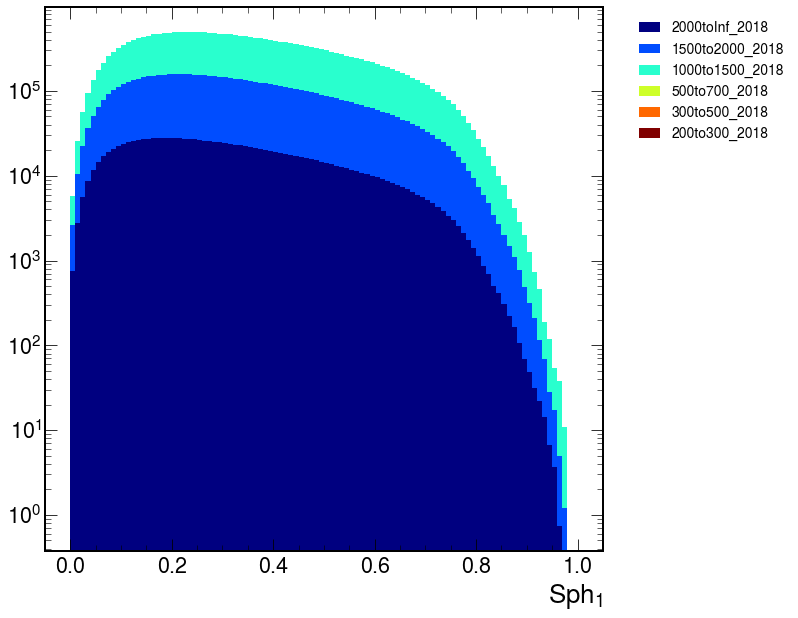

In [7]:
plot_labels = ['SUEP_S1_Cluster']
#samples = ['1500to2000', '500to700', '100to200', '200to300', '300to500', '2000toInf', '1000to1500']
samples = ['200to300_2018', '1000to1500_2018', '500to700_2018',
           '2000toInf_2018', '300to500_2018', '1500to2000_2018']
for plot_label in plot_labels:
        
    # get hists
    hlist, labels = [], []
    for sample in samples:
        print(sample)
        hlist.append(plots[sample][plot_label])
        labels.append(sample)
                        
    # not sure why, but they NEED to be color coded appropriately
    vals = []
    for key in labels:
        key = key.split("_")[0]
        keyslice = key.split("to")[0]
        val = int(keyslice)
        vals.append(val)
    hlist_sorted, labels_sorted = [], []
    for arg in np.argsort(vals)[::-1]:
        hlist_sorted.append(hlist[arg])
        labels_sorted.append(labels[arg])
        
    cmap = plt.cm.jet(np.linspace(0, 1, len(labels_sorted)))
    
    hep.histplot(hlist_sorted, yerr=True, stack=True, histtype ='fill',
                 label=labels_sorted, color=cmap)
    
    plt.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.yscale("log")
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

## ABCD
Make the ABCD regions by hand from one of the 2D plots.<br>
Notation: `hist[v1:v2::sum]` sums along an axis from v1 to v2 (leave either blank to extend the summation bounds arbitrarily).

### ABCD Independent Variables Check
1D slices of 2D plots, usually used to check the independence of the ABCD method's two variables on the QCD sample. This won't work if QCD has been binned by pt. <br>
N.B.: Imaginary numbers are used to access the bin value; using real numbers would access the bin number (see hist documentation for more info).<br>
Parameters:<br>
`plot_label`:_str_, which plot to analyze.<br>
`sample`: _str_, which sample to analyze.<br>
`variables`: _str_, variables being sliced, used to pick the slices in the loop.<br>
`slices`: _list of lists of floats_, bins of values to be sliced. e.g. for equal slices use np.linspace(start, end, number of bins), if not can specify as [[0,10],[20,40],[40,50],...].

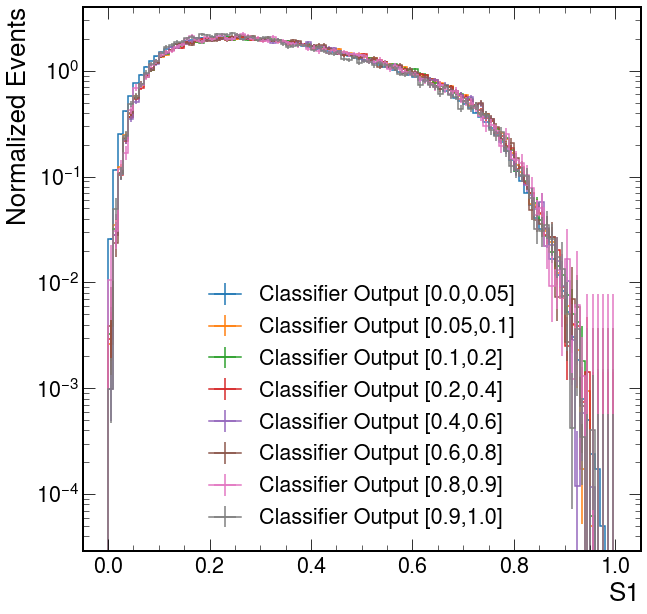

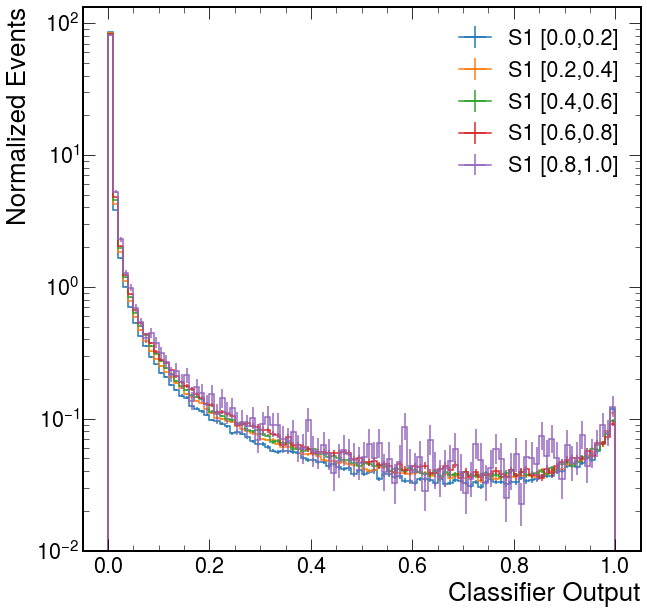

In [27]:
# parameters
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_GNN'
sample = 'QCD_HT_2018'
variables = ['S1', 'Classifier Output']

for i in range(2):
    
    slice_label = variables[(i+1)%2]
    
    # some predefined slices
    if slice_label == '# Tracks': slices = [[0.0j,40j],[40j,80j],[80j,120j],[120j,140j],[140j,160j],[160j,500j]]
    elif slice_label == '# Const': slices = [[0.0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,300j]]
    elif slice_label == 'pT Avg': slices = [[0.0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,1000j]]
    elif slice_label == 'pT Avg b': slices = [[0.0j,2j],[2j,4j],[4j,6j],[6j,10j],[10j,1000j]]
    elif slice_label == 'pT Mean Scaled': slices = [[0.0j, 0.1j],[0.1j,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j, 1.0j]]
    elif slice_label == 'Classifier Output': slices = [[0.0j,0.05j],[0.05j,0.1j],[0.1j,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j,0.8j],[0.8j,0.9j], [0.9j,1.0j]]
    elif slice_label == 'S1': slices = [[0.0j,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j,0.8j],[0.8j,1.0j]]

    h = plots[sample][plot_label]
    
    if i==0:  
        h = h[:,:]
        hlist = slice_hist2d(h, slices, slice_var='y')
    if i==1:  
        h = h[:,:]
        hlist = slice_hist2d(h, slices, slice_var='x')
    
    for h, s in zip(hlist, slices):
        hep.histplot(h,
                     yerr=True, density=True, 
                     label=slice_label+" [{0},{1}]".format(s[0].imag, s[1].imag))    
    
    plt.legend()
    # plt.ylim(1e-5,1e1)
    plt.yscale('log')
    plt.ylabel("Normalized Events")
    plt.xlabel(variables[i])
    plt.savefig(output_label + plot_label + "_" + slice_label.replace("#","n").replace(" ","_") + "_SLICES" + file_ext,  bbox_inches='tight')
    plt.show()

### 4 Regions
Check closure in D region for one sample.

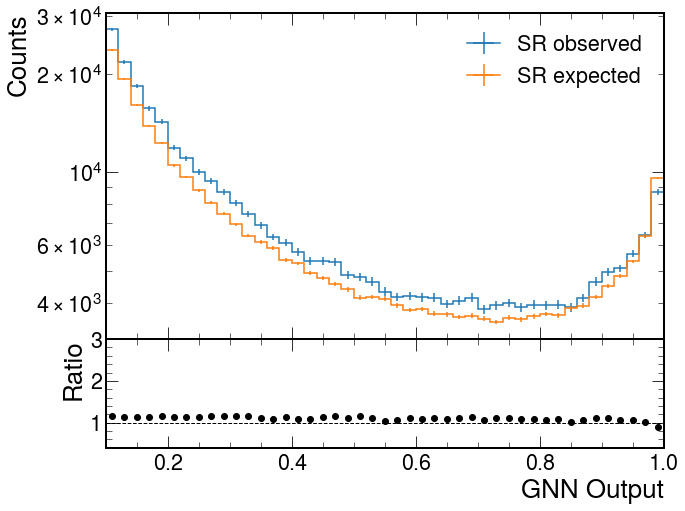

In [33]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_GNN'
abcd = plots['QCD_HT_2018'][plot_label]
xregions = [0.0j, 0.5j, 1.0j]
yregions = [0.0j, 0.1j, 1.0j]

SR, SR_exp = ABCD_4regions(abcd, xregions, yregions, sum_var='x')

SR = SR[::2j]
SR_exp = SR_exp[::2j]

fig = plt.figure(figsize=(10, 8))
main, sub = SR.plot_ratio(SR_exp,
                rp_num_label='SR observed',
                rp_denom_label='SR expected')
fig.axes[0].set_yscale("log")
fig.axes[1].set_ylim(0.4,3)
#fig.axes[1].set_xlim(80,200)
plt.savefig(output_label+"ABCD_"+plot_label+file_ext)

### 6 Regions

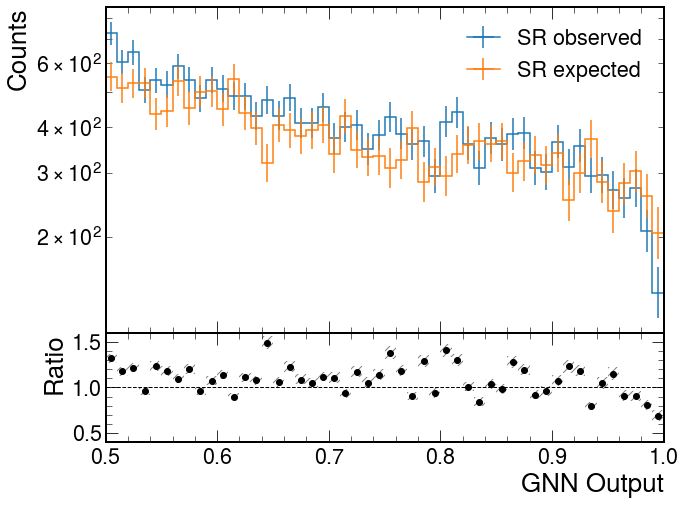

In [20]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
abcd = plots['QCD_HT_2018'][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.3j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')

fig = plt.figure(figsize=(10, 8))
main, sub = SR.plot_ratio(SR_exp,
                rp_num_label='SR observed',
                rp_denom_label='SR expected',
                rp_uncert_draw_type="bar")
fig.axes[0].set_yscale("log")
fig.axes[1].set_ylim(0.4,1.6)
plt.savefig(output_label+"ABCD_6regions_"+plot_label+file_ext)

### 9 Regions

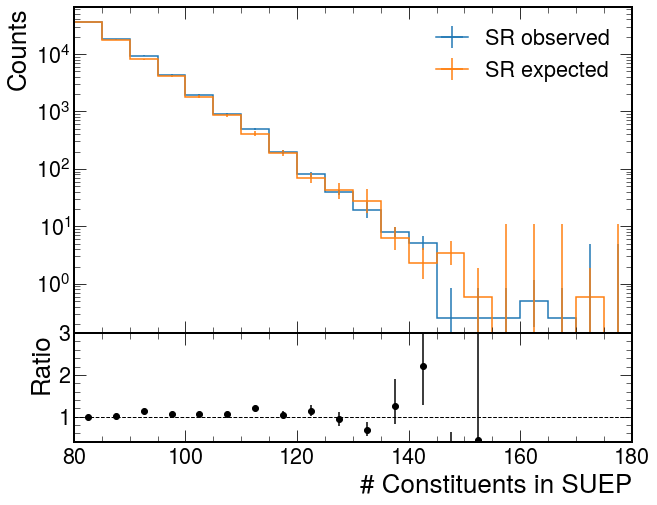

In [60]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
abcd = plots['QCD_HT_2018'][plot_label]

xregions = [0.35j, 0.4j, 0.5j, 1.0j]
yregions = [10j, 40j, 80j, 300j]

SR, SR_exp = ABCD_9regions(abcd, xregions, yregions, sum_var='x')

SR = SR[::2j]
SR_exp = SR_exp[::2j]

fig = plt.figure(figsize=(10, 8))
main, sub = SR.plot_ratio(SR_exp,
                rp_num_label='SR observed',
                rp_denom_label='SR expected')
fig.axes[0].set_yscale("log")
fig.axes[0].set_xlim(80,180)
fig.axes[1].set_ylim(0.4,3)
fig.axes[1].set_xlabel("# Constituents in SUEP")
plt.savefig(output_label+"ABCD_9regions_"+plot_label+file_ext)

In [65]:
abcd = plots['QCD_HT_2018'][plot_label]
SR = abcd[0.5j:,80j:]
SR.sum()

WeightedSum(value=71174.5, variance=175581)

In [66]:
abcd = plots['SUEP-m1000-generic'][plot_label]
SR = abcd[0.5j:,80j:]
SR.sum()

WeightedSum(value=1609.38, variance=9811.04)

#### 9 Regions with error propagation

Scaling factor alpha: 2.25529877434109
Sigma alpha: 0.0236382446747791


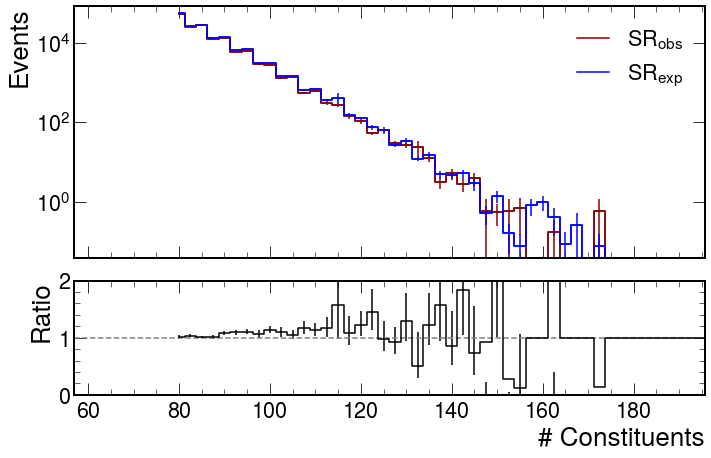

In [19]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
abcd = plots['QCD_HT_allyears'][plot_label]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
xregions = [0.35j, 0.4j, 0.5j, 1.0j]
yregions = [10j, 40j, 80j, 300j]

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [20j, 40j, 60j, 300j]

# 2D_ISR_S1_ISR_nconst_CL
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [0.0j, 30j, 60j, 300j]

# 2D_SUEP_S1_SUEP_nconst_CL (scouting)
# xregions = [0.35j, 0.4j, 0.5j, 1.0j]
# yregions = [10.0j, 35j, 60j, 300j]

SR, SR_exp, alpha, sigma_alpha = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

print("Scaling factor alpha:", alpha)
print("Sigma alpha:", sigma_alpha)

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
fig, axs, _ = plot_ratio(SR_exp, SR, label1="$SR_{obs}$", label2="$SR_{exp}$")
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend()

In [24]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster'
samples = ['QCD_HT_2018', 'SUEP-m125-generic', 'SUEP-m125-generic-htcut', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']

# 2D_SUEP_S1_vs_SUEP_nconst_Cluster
# 2D_ISR_S1_vs_ISR_nconst_ClusterInverted
xregions = [0.35j, 0.4j, 0.5j, 1.0j]
yregions = [10j, 40j, 80j, 300j]

hlist = []
for sample in samples:
    abcd = plots[sample][plot_label]
    SR = abcd[xregions[-2]:xregions[-1], yregions[-2]:yregions[-1]]
    hlist.append(SR)

import uproot 
# save to root
with uproot.recreate('SR_2018.root') as froot:
    for l, h in zip(labels, samples):
        froot[l] = h

### Residuals

In [ ]:
plot_label = '2D_SUEP_S1_ntracks_IRM'
var_label = 'S1'
sample1 = 'QCD_HT'
sample2 = 'data'

abcd = plots[sample1][plot_label]
A = abcd[0.35j:0.5j,0j:100j:sum]
B = abcd[0.35j:0.5j,100j::sum]
C = abcd[0.5j:1.0j,0j:100j:sum]
D_exp = C * B.sum().value / A.sum().value

abcd2 = plots[sample2][plot_label]
A2 = abcd2[0.35j:0.5j,0j:100j:sum]
B2 = abcd2[0.35j:0.5j,100j::sum]
C2 = abcd2[0.5j:1.0j,0j:100j:sum]
D_exp2 = C2 * B2.sum().value / A2.sum().value

hists, hists2  = [A,B,C,D_exp], [A2, B2, C2, D_exp2]
labels = ['A','B','C','D_exp']
avgs, errs = [], []
for h1, h2, label in zip(hists, hists2, labels):
    
    h1 = h1/h1.sum().value
    h2 = h1/h2.sum().value
    fig, _, res = plot_ratio(h1, h2, var_label, sample1, sample2)
    plt.close()
    
    residuals = res[0]
    residual_stddevs = []
    for e1, e2 in zip(res[1][0], res[1][1]):
        if np.isinf(e1) and np.isinf(e2):
            print("well well well")
        elif np.isinf(e2):
            residual_stddevs.append(e1)
        elif np.isinf(e1):
            residual_stddevs.append(e1)
        else:
            residual_stddevs.append(max(e1,e2))
    residual_vars = np.array(residual_stddevs)**2
    residuals = abs(residuals[~np.isnan(residual_vars)])
    residual_vars = residual_vars[~np.isnan(residual_vars)]
    
    # Using Hist's fancy tools
    # wmean.value equivalent to np.sum(residuals/residual_vars) / np.sum(1/residual_vars)
    wmean = hist.accumulators.WeightedMean().fill(residuals, weight=1/residual_vars)
    
    # why is this difference from np.sqrt(wmean.variance)
    #test2 = 1/np.sqrt(np.sum(1/residual_vars))
    #print(test2, np.sqrt(wmean.variance))
    
    avgs.append(wmean.value)
    errs.append(np.sqrt(wmean.variance))
    
from IPython.display import display, Latex
for i in range(len(labels)):
    display(Latex(labels[i] + ' ' + str(round(avgs[i],3)) + '$\pm$' + str(round(errs[i],3))))

## Systematics

### Track Killing

KeyError: 'SUEP_nconst_Cluster_trackDOWN'

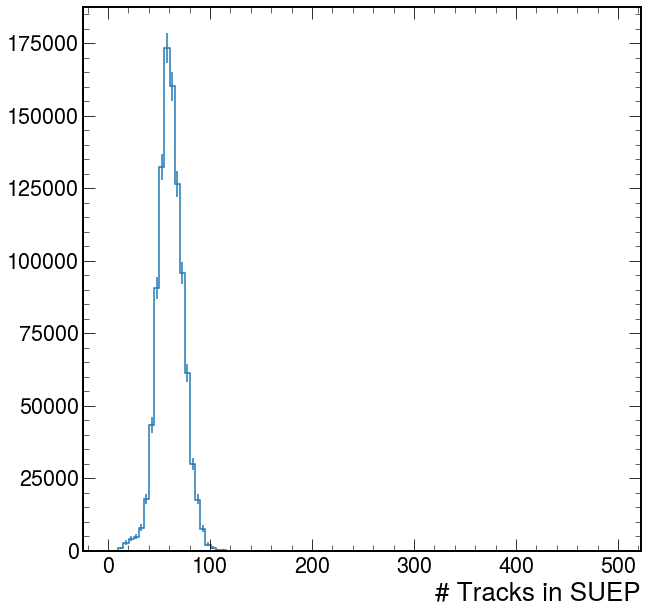

In [42]:
plot_label = 'SUEP_nconst_Cluster'
sample = 'SUEP-m125-generic-htcut'
sys = ['', '_trackDOWN', '_trackUP']
labels = ['Nominal', 'Tracks Down', 'Tracks Up']

for s, l in zip(sys, labels):
    h = plots[sample][plot_label + s]
    hep.histplot(h[::2j], label=l)
_ = plt.legend()
plt.yscale('log')
plt.xlim(0,125)

### Jet Energies

KeyError: 'ht_JEC_Cluster_JEC'

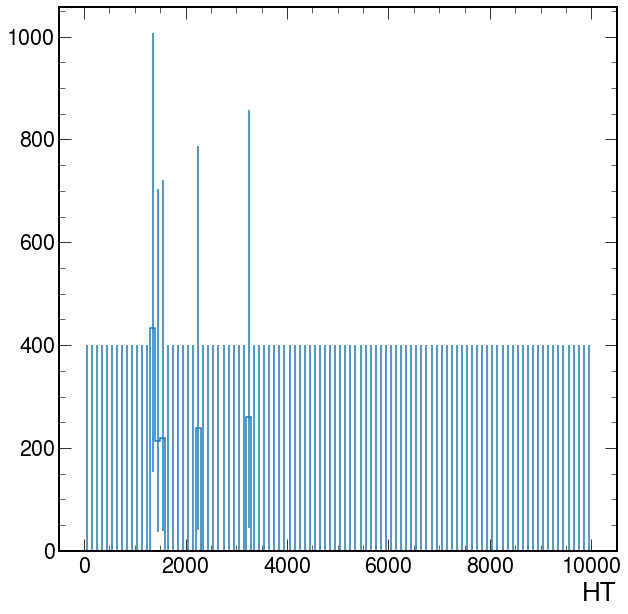

In [40]:
plot_label = 'ht_Cluster'
sample = 'SUEP-m125-generic'
sys = ['', '_JEC', '_JEC_JER_up', '_JEC_JER_down', '_JEC_JES_up', '_JEC_JES_down']
labels = ['Nominal', 'JEC', 'JEC_JER_up', 'JEC_JER_down', 'JEC_JES_up', 'JEC_JES_down']

for s, l in zip(sys, labels):
    h = plots[sample][plot_label.replace("_Cluster", s + "_Cluster") + s]
    hep.histplot(h, label=l)
_ = plt.legend()
plt.yscale('log')

### GNN

(0.5, 2.5)

<Figure size 720x576 with 0 Axes>

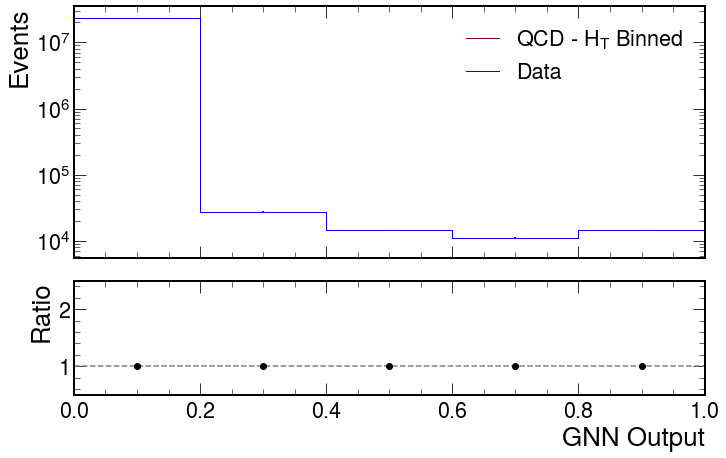

In [26]:
# parameters
plot_label = '2D_ISR_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted'
sample1 = 'QCD_HT_2018'
sample2 = 'QCD_HT_2018'

h1 = plots[sample1][plot_label]
h2 = plots[sample2][plot_label]

h1 = h1[0.0j::sum, 0.0j::20j]
h2 = h2[0.0j::sum, 0.0j::20j]

fig = plt.figure(figsize=(10, 8))
      
fig, axs, _ = new_plot_ratio(h1, h2, label1=r'QCD - $H_T$ Binned', label2 = 'Data')
axs[0].legend()
axs[1].set_ylim(0.5,2.5)
#axs[0].set_yscale("linear")

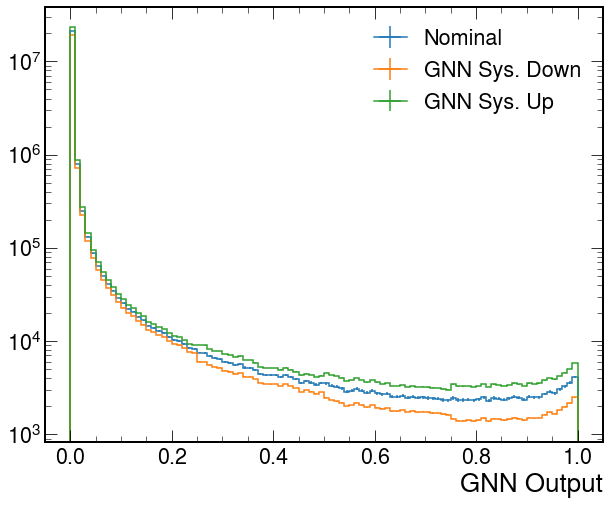

In [11]:
# parameters
plot_label = 'single_l5_bPfcand_S1_SUEPtracks_GNN'
sample = 'QCD_HT_2018'

h1 = plots[sample][plot_label]
h2 = plots[sample][plot_label + "_down_GNN"]
h3 = plots[sample][plot_label + "_up_GNN"]


fig = plt.figure(figsize=(10, 8))
      
hep.histplot(h1, label='Nominal')
hep.histplot(h2, label="GNN Sys. Down")
hep.histplot(h3, label="GNN Sys. Up")

plt.legend()
plt.yscale("log")

In [8]:
[k for k in plots['QCD_HT_2018'] if 'single' in k]

['2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN',
 '2D_SUEP_nconst_vs_single_l5_bPfcand_S1_SUEPtracks_GNN',
 'single_l5_bPfcand_S1_SUEPtracks_GNN',
 'A_single_l5_bPfcand_S1_SUEPtracks_GNN',
 'B_single_l5_bPfcand_S1_SUEPtracks_GNN',
 'C_single_l5_bPfcand_S1_SUEPtracks_GNN',
 'D_single_l5_bPfcand_S1_SUEPtracks_GNN',
 'E_single_l5_bPfcand_S1_SUEPtracks_GNN',
 'F_single_l5_bPfcand_S1_SUEPtracks_GNN',
 '2D_ISR_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted',
 '2D_ISR_nconst_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted',
 'single_l5_bPfcand_S1_SUEPtracks_GNNInverted',
 'A_single_l5_bPfcand_S1_SUEPtracks_GNNInverted',
 'B_single_l5_bPfcand_S1_SUEPtracks_GNNInverted',
 'C_single_l5_bPfcand_S1_SUEPtracks_GNNInverted',
 'D_single_l5_bPfcand_S1_SUEPtracks_GNNInverted']

## Calculate Yields
Integrate histograms to calculate yields.<br>
Parameters:<br>
`lumi`: _float_, scales MC data.<br>
`plot_label`: _str_, which plot you want to integrate.

In [15]:
plot_label = 'single_l5_bPfcand_S1_SUEPtracks_GNN'
samples = ['QCD_HT_2018']
samples += ['SUEP-m125-generic', 'SUEP-m400-generic',
           'SUEP-m750-generic', 'SUEP-m1000-generic']
# samples += ['SUEP-m125-darkPho', 'SUEP-m400-darkPho',
#            'SUEP-m750-darkPho', 'SUEP-m1000-darkPho']
# samples += ['SUEP-m125-darkPhoHad', 'SUEP-m400-darkPhoHad',
#            'SUEP-m750-darkPhoHad', 'SUEP-m1000-darkPhoHad']

for sample in samples:
    h = plots[sample][plot_label]
    passing = h[0.5j:].sum().value
    total = h.sum().value
    print(sample, round(passing/total, 3))

QCD_HT_2018 0.006
SUEP-m125-generic 0.333
SUEP-m400-generic 0.909
SUEP-m750-generic 0.984
SUEP-m1000-generic 0.992


## ROC Curve

SUEP_nconst_GNN
single_l5_bPfcand_S1_GNN


Text(0, 1, 'TPR')

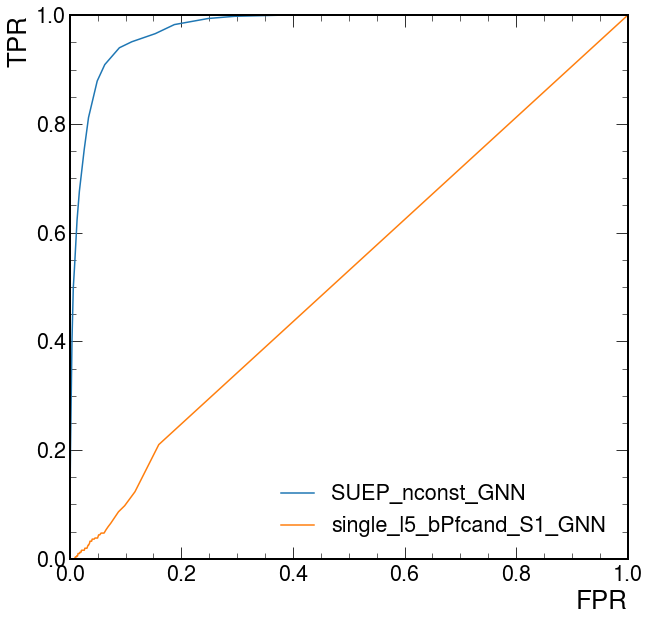

In [18]:
from sklearn.metrics import roc_curve

def roc_from_hists(h_sig, h_bkg, max_value=None, steps=100000):
    
    TPRs, FPRs = [], []
    if max_value is None:
        h_sig_max = h_sig.to_numpy()[1][-1]
        h_bkg_max = h_bkg.to_numpy()[1][-1]
        max_value = max(h_sig_max, h_bkg_max)
    for threshold in np.linspace(0, max_value, steps):
        TPR = integrate(h_sig, threshold*1j, 10000000j)[0] / h_sig.sum().value
        FPR = integrate(h_bkg, threshold*1j, 10000000j)[0] / h_bkg.sum().value
        TPRs.append(TPR)
        FPRs.append(FPR)

    return TPRs, FPRs


"""
SUEP-m400-md2-t0.5-generic
SUEP-m400-md2-t1-generic
SUEP-m400-md2-t2-generic
SUEP-m400-md2-t3-generic
SUEP-m400-md2-t4-generic
SUEP-m400-md3-t1.5-generic
SUEP-m400-md3-t3-generic
SUEP-m400-md3-t6-generic
SUEP-m400-md5-t1-generic
SUEP-m400-md5-t10-generic
SUEP-m400-md5-t5-generic
"""



sample_sig = 'SUEP-m400-md3-t6-generic'
sample_bkg = 'QCD_HT_2018'
classifiers = ['SUEP_nconst_GNN', 'single_l5_bPfcand_S1_GNN']

fig = plt.figure()
ax = fig.subplots()

for plot in classifiers:
    print(plot)
    h_bkg = plots[sample_bkg][plot]
    h_sig = plots[sample_sig][plot]
    TPRs, FPRs = roc_from_hists(h_sig, h_bkg, steps=1000)
    TPRs, FPRs = roc_from_hists(h_sig, h_bkg, steps=1000)
    ax.plot(FPRs, TPRs, label=plot)
    
ax.set_xlim(0,1)
ax.set_ylim(0,1.0)
ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

## Table

Make comparison table by running next cells. The output is meant to be in Latex format.<br>
The `stats` nested dictionary stores the number of events and variances in each region for real data and MC data when the plots are made, and is used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [ ]:
# dimensions: (sample) x (plot label) x (value or error on the value)
stats = nested_dict(4,float)
selection = 'ch'

for plot_label in ['A','B','C','D_exp']:
    
    plot_label+="_"+selection
    
    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
        
    # fill these up for the table
    stats['data'][plot_label]["value"] = hdata.sum().value
    stats['data'][plot_label]["err"] = hdata.sum().variance
    stats['QCD_MC'][plot_label]["value"] = hQCD_MC.sum().value
    stats['QCD_MC'][plot_label]["err"] = hQCD_MC.sum().variance

In [ ]:
table = []
for i in range(len(list(stats.keys()))):
    label = list(stats.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD_MC' in label:
            line.append("{:0.0f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(stats[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(stats[label][r]['err']))
        
    if 'QCD_MC' in label:
        line.append(round((stats[label]['D_exp_'+selection]['value']-stats[label]['D_obs_'+selection]['value'])/stats[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(stats[label]['D_obs_'+selection]['value']/math.sqrt(stats[label]['D_obs_'+selection]['value']+stats[label]['D_exp_'+selection]['value']+stats[label]['D_obs_'+selection]['err']+stats['QCD_MC']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [ ]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

In [ ]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t

In [7]:
isr2d = plots['QCD_HT_2018']['2D_ISR_S1_vs_ISR_nconst_ClusterInverted']
suep2d = plots['QCD_HT_2018']['2D_SUEP_S1_vs_SUEP_nconst_Cluster']

In [25]:
slices = []
for ybin in range(isr2d.shape[1] - 1):
    isr_slice = isr2d[:,ybin:ybin+1:sum]
    suep_slice = suep2d[:,ybin:ybin+1:sum]
    if isr_slice.sum().value == 0: continue
    ratio = suep_slice.sum().value/isr_slice.sum().value
    
    slices.append(isr_slice.view().value * ratio)

In [34]:
hISR_S1 = Hist.new.Reg(100, 0, 1.0, name="ISR_S1", label='$Sph_1$').Weight()

In [39]:
for s in slices: hISR_S1.view().value += s

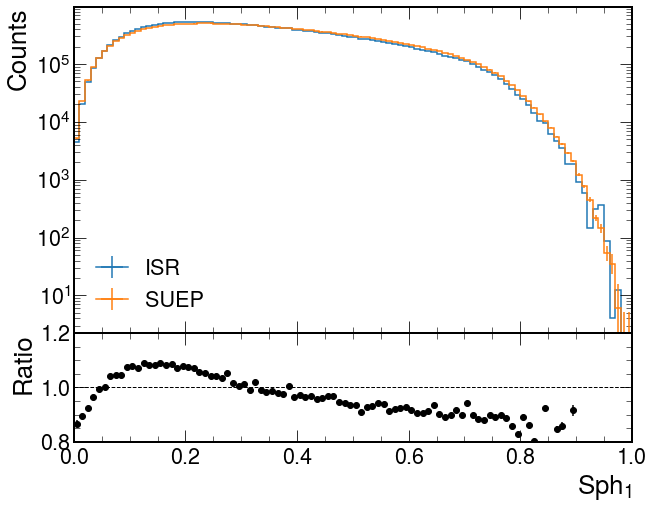

In [53]:
fig = plt.figure(figsize=(10, 8))
_ = hISR_S1.plot_ratio(suep2d[:,::sum],
                      rp_num_label='ISR',
                      rp_denom_label='SUEP')
fig.axes[0].set_yscale("log")
_ = fig.axes[0].legend()
_ = fig.axes[1].set_ylim(0.8,1.2)